In [2]:
import pandas as pd
import numpy as np
import sys,os
import matplotlib.pyplot as plt
import plot_utils
import concurrent.futures
import importlib
import seaborn as sns

In [3]:

# CIFAR ICML experiments
# target_dir = "my_results/icml_experiments/cifar10/"
# ORDERINGS = {
#     "noise_level" : ["nonoise","1th","2th","4th","5th,""8th","16th","32th","64th","128th"],
#     "variant":["nonoise","zerosum","muffliato"],
#     "avgsteps": ["10avgsteps", "1avgsteps"],
#     "topology_type": ["static","dynamic"],
# } 

#CIFAR Additional runs with seeds:
# target_dir = "my_results/icml_experiments/additional_cifar10_v2/"
# ORDERINGS = {
#     "noise_level" : ["nonoise","4th","64th"],
#     "variant":["nonoise","zerosum","muffliato"],
#     "avgsteps": ["10avgsteps", "1avgsteps"],
#     "topology_type": ["static","dynamic"],
# } 


# Muffliato experiments on CIFAR with multiple avg steps
# target_dir = "my_results/icml_experiments/muffliato_avgsteps"
# ORDERINGS = {
#     "noise_level" : ["4th","16th","64th"],
#     "variant":["muffliato","zerosum"],
#     "avgsteps": ["20avgsteps", "15avgsteps", "10avgsteps","5avgsteps", "1avgsteps"].reverse(),
#     "topology_type": ["static","dynamic"],
# }

# Tryouts for Femnist
# target_dir = "my_results/test/testing_femnist_convergence_rates/"
# ORDERINGS = {
#     "noise_level" : ["nonoise","1th","2th","4th","5th,""8th","16th","32th","64th","128th"],
#     "variant":["nonoise","zerosum","muffliato"],
#     "avgsteps": ["10avgsteps", "1avgsteps"],
#     "topology_type": ["static","dynamic"],
# } 


#Tryouts for CIFAR
# target_dir = "my_results/test/testing_convergence_rates/"

# TOTAL_PROCESSES = 128
# MAX_MACHINES =  8
# MAX_ITERATIONS=10000
# STARTING_ITERATION = 0

# S&P Femnist experiments
target_dir = "my_results/sp_experiments/"
ORDERINGS = {
    "noise_level" : ["nonoise","1th","2th","4th","5th,""8th","16th","32th","64th","128th"],
    "variant":["nonoise","zerosum","muffliato"],
    "avgsteps": ["5avgsteps", "1avgsteps"],
    "topology_type": ["static","dynamic"],
} 

TOTAL_PROCESSES = 64
MAX_MACHINES =  4
MAX_ITERATIONS=5000
STARTING_ITERATION = 0

linestyles = {
    "ZeroSum" : "--"
}

fontsize=20

alpha = 0.1

save_directory = "assets/"

NOISES_MAPPING ={
    "nonoise":0,
    "0p25th": 0.225 / 0.25,
    "0p5th": 0.225 / 0.5,
    "0p75th": 0.225 / 0.75,
    "1th": 0.225,
    "2th": 0.1125,
    "2p5th": 0.225 / 2.5,
    "3th": 0.225 / 3,
    "3p5th": 0.225 / 3.5,
    "4th": 0.05625,
    "5th": 0.225 / 5,
    "6th": 0.225 / 6,
    "7th": 0.225 / 7,
    "8th": 0.028125,
    "16th": 0.0140625,
    "32th": 0.00703125,
    "64th": 0.003515625,
    "128th": 0.001757813,
}

assert TOTAL_PROCESSES%MAX_MACHINES == 0
MAX_PROCESSES = TOTAL_PROCESSES//MAX_MACHINES

In [4]:
# Load the file list
experiments_dict = plot_utils.get_full_path_dict(target_dir)
experiments_attributes = plot_utils.get_experiments_dict(experiments_dict)

experiments_attributes_df = pd.DataFrame({})
for experiment_name,experiment_attribute in sorted(experiments_attributes.items()):
    print(experiment_name)
    experiments_attributes_df = pd.concat([experiments_attributes_df,pd.DataFrame(experiment_attribute,index=[experiment_name])])
# print(experiments_attributes_df.columns)

# print(experiments_attributes["4447548_muffliato_128nodes_10avgsteps_64th_dynamic_seed105"])

for seed in range(91,105): 
    print(f"Seed: {seed:3.0f}:", end= "")
    current_seed = experiments_attributes_df[experiments_attributes_df["seed"] == f"seed{seed}"]
    current_variants = list(current_seed["variant"])
    current_topologies = list(current_seed["topology_type"])
    print(sorted(list(zip(current_variants,current_topologies))))


2382294_nonoise_64nodes_1avgsteps_static_seed90_degree6_RNET_lr0.10_1rounds
2382295_zerosum_selfnoise_64nodes_1avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1rounds
2382296_zerosum_selfnoise_64nodes_1avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1rounds
2382297_zerosum_selfnoise_64nodes_1avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1rounds
2382298_zerosum_selfnoise_64nodes_1avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1rounds
2383059_muffliato_64nodes_5avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1rounds
2383060_muffliato_64nodes_5avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1rounds
2383145_muffliato_64nodes_5avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1rounds
2383146_muffliato_64nodes_5avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1rounds
2383147_muffliato_64nodes_5avgsteps_64th_static_seed90_degree6_RNET_lr0.10_1rounds
2383148_muffliato_64nodes_5avgsteps_4th_static_seed90_degree6_RNET_lr0.10_1rounds
Seed:  91:[]
Seed:  92:[]
Seed:  93:[]
Seed:  94:[]
Seed:  95:[]


In [4]:
machine_folder = 'machine{}'
result_file = '{}_results.json'


def load_data(dir):
    data = pd.DataFrame({})
    for machine in range(MAX_MACHINES):
        for rank in range(MAX_PROCESSES):
            # print(f"Loading results for machine {machine} and rank {rank}.  ",end = "\r")
            uid = rank + machine * MAX_PROCESSES

            file = os.path.join(dir, machine_folder.format(machine), result_file.format(rank))
            tmp_df = pd.read_json(file)
            tmp_df["uid"] = uid # Manually add the uid for further processing                                                                   
            tmp_df["iteration"] = tmp_df.index
            # print(tmp_df)
            tmp_df = tmp_df[tmp_df["iteration"]>=STARTING_ITERATION]
            tmp_df = tmp_df[tmp_df["iteration"]<=MAX_ITERATIONS]
            data = pd.concat([data,tmp_df])
    return data

def load_attack_results(current_experiment_data,experiment_dir):
    experiment_name = os.path.basename(experiment_dir)
    expected_file_name = "threshold_" + experiment_name + ".csv"
    directories = sorted(os.listdir(experiment_dir))
    
    if expected_file_name not in directories:
        print(f"Not loading attack results: {expected_file_name} was not listed with attack results in {experiment_dir}. Entire directory:\n{directories}")
        return current_experiment_data
    attacks_df = pd.read_csv(os.path.join(experiment_dir,expected_file_name))
    attacks_df = attacks_df.drop(columns = "Unnamed: 0")
    attacks_df = attacks_df.rename(columns = {"agent":"uid"})
    # print(attacks_df.columns)
    # print(current_experiment_data)
    # print(attacks_df)
    
    res = pd.merge(current_experiment_data, attacks_df,on = ["uid","iteration"],how="outer" )
    # print(res)
    return res

def load_linkability_attack_results(current_experiment_data,experiment_dir):
    experiment_name = os.path.basename(experiment_dir)
    expected_file_name = f"linkability_{experiment_name}.csv"
    directories = sorted(os.listdir(experiment_dir))
    if expected_file_name not in directories:
        print(f"Not loading attack results: {expected_file_name} was not listed with attack results in {experiment_dir}. Entire directory:\n{directories}")
        return current_experiment_data
    
    linkability_attack_df = pd.read_csv(os.path.join(experiment_dir,expected_file_name))

    linkability_attack_df = linkability_attack_df.rename(columns = {"agent":"uid"})

    return pd.merge(current_experiment_data,linkability_attack_df,on = ["uid","iteration"],how="outer")

# Function to recompute some of the linkability attack results. Should only be used if there are errors in the data (see perform_attack.py).
def fix_linkability_attack_results(experiment_name,attack_results_path):
    expected_file_name = f"linkability_{experiment_name}.csv"
    directories = sorted(os.listdir(attack_results_path))
    if expected_file_name not in directories:
        print(f"Not loading attack results: {expected_file_name} was not listed with attack results in {attack_results_path}. Entire directory:\n{directories}")
        raise FileNotFoundError(expected_file_name)
    
    linkability_attack_df = pd.read_csv(os.path.join(attack_results_path,expected_file_name))
    
    # Fixing all the missing values/wrongly filled values  
    linkability_attack_df["linkability_top1"] = (linkability_attack_df["linkability_top1_guess"]==linkability_attack_df["agent"])
    
    linkability_attack_df.reset_index(drop = True)
    linkability_attack_df.set_index(["agent","iteration"])
    columns = linkability_attack_df.columns.to_list()
    columns_losses = [column for column in columns if "loss_trainset_" in column]
    
    linkability_attack_df["linkability_real_rank"] = np.nan
    linkability_attack_df["linkability_real_rank"].astype('Int64',copy=False)
    for index,row in linkability_attack_df.iterrows():
        losses = [(int(column.split("_")[2]),row[column]) for column in columns_losses]
        losses_sorted = sorted(losses, key = lambda x:x[1])
        agents_sorted = [x[0] for x in losses_sorted]
        current_agent = row["agent"]
        linkability_rank = agents_sorted.index(current_agent)
        linkability_attack_df.at[index,"linkability_real_rank"] = linkability_rank
    
    linkability_attack_df = linkability_attack_df.drop(columns = "Unnamed: 0")
    linkability_attack_df.to_csv(os.path.join(attack_results_path,f"fixed_{expected_file_name}"))
    
    return linkability_attack_df

def load_data_element(experiment_dir):
    name = os.path.basename(experiment_dir)
    print(f"Loading data from {name}")
    current_results = load_data(experiment_dir).dropna()
    current_results = load_attack_results(current_results,experiment_dir)
    current_results = load_linkability_attack_results(current_results,experiment_dir)
    # input_dict[name] = current_results
    attributes = plot_utils.get_attributes(name)
    for attribute, attribute_value in attributes.items():
        current_results[attribute] = attribute_value
    
    print(f"Finished loading data from {name}")
    return current_results


loaded_data = {}

with concurrent.futures.ProcessPoolExecutor(max_workers=20) as executor:
    futures = {}
    for name,filepath in sorted(experiments_dict.items()):
        # res = load_data_element(filepath)
        # print(res)
        # break
    
        futures[name] = executor.submit(load_data_element,filepath)
        
        
        # fix_linkability_attack_results(name,attack_results_path=ATTACK_RESULTS_PATH)
        # break
    for name, result in futures.items():
        print(f"Adding data from {name}")
        loaded_data[name]=result.result()
# print(loaded_data)
print("Finished loading all data")

Loading data from 2382296_zerosum_selfnoise_64nodes_1avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1roundsLoading data from 2382295_zerosum_selfnoise_64nodes_1avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1roundsLoading data from 2382294_nonoise_64nodes_1avgsteps_static_seed90_degree6_RNET_lr0.10_1roundsLoading data from 2382297_zerosum_selfnoise_64nodes_1avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1roundsLoading data from 2383059_muffliato_64nodes_5avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1roundsLoading data from 2382298_zerosum_selfnoise_64nodes_1avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1roundsLoading data from 2383146_muffliato_64nodes_5avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1roundsLoading data from 2383060_muffliato_64nodes_5avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1roundsLoading data from 2383145_muffliato_64nodes_5avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1rounds
Loading data from 2383147_muffliato_64nodes_5avgsteps_64th_static_seed90_deg

In [9]:
general_agg_methods = ["mean", "std", "sum","min","max",plot_utils.percentile(0.5),plot_utils.percentile(0.95)]
columns_to_agg = ["train_loss","test_loss", "test_acc", "total_bytes", "total_meta", "total_data_per_n", "roc_auc"]
# columns_to_agg = ["train_loss","test_loss", "test_acc", "total_bytes", "total_meta", "total_data_per_n"]


def count_percentage_success(column:pd.Series):
    counts = column.value_counts(normalize=True)
    if True not in counts:
        return np.nan
    res = counts[True]
    return res 



# linkability_aggregators = {
#     "linkability_top1": [count_percentage_success],
#     "linkability_top5": [count_percentage_success],
#     "linkability_real_rank": ["median","min","max"],
# }
linkability_aggregators = {}

def start_avg(column:pd.Series):
    res = []
    running_elements:pd.Series = pd.Series({})
    for (index,value) in column.items():
        if np.isnan(value):
            res.append(np.NaN)
        elif running_elements.empty:
            running_elements = pd.Series(value)
            res.append(value)
        else:
            running_elements = pd.concat([running_elements,pd.Series(value)])
            res.append(running_elements.mean()) 
    return res



to_start_avg = ["roc_auc mean","linkability_top1 count_percentage_success","roc_auc max"]
to_start_avg = []
general_aggregator = {column:general_agg_methods for column in columns_to_agg}

general_aggregator.update(linkability_aggregators) 


def format_data(data,key):
    usable_data = data[["iteration"] + columns_to_agg +  list(linkability_aggregators.keys())]
    grouped_data = usable_data.groupby(['iteration']) 
    usable_data = grouped_data.agg(general_aggregator)
    usable_data.reset_index(inplace=True)
    usable_data.set_index("iteration",inplace=True)

    usable_data.insert(1,"experience_name",key)
    usable_data.insert(2,"number_agents",TOTAL_PROCESSES)

    usable_data.columns = [' '.join(e) if len(e[-1])>0 else e[0] for e in usable_data.columns]

    
    
    experiment_attributes = plot_utils.get_attributes(key)
    for attribute, attribute_value in experiment_attributes.items():
        usable_data[attribute] = attribute_value
    
    # Compute an additional column: "{column}_start_avg"
    for column_name in to_start_avg:
        rolled_average = start_avg(usable_data[column_name])
        usable_data[column_name + "_start_avg"] =  rolled_average
        usable_data[column_name + "_cum_sum"] = usable_data[column_name].cumsum()
        # print(usable_data[column_name + "_start_avg"].dropna() )
    
    usable_data["noise_level_value"] = usable_data["noise_level"].apply(lambda x : NOISES_MAPPING[x])
    
    return usable_data



formatted_data = {}
for name,data in sorted(loaded_data.items()):
    print(f"Formatting {name}")
    formatted_data[name] = format_data(data,name)
formatted_data[list(formatted_data)[0]].columns

Formatting 2382294_nonoise_64nodes_1avgsteps_static_seed90_degree6_RNET_lr0.10_1rounds
Formatting 2382295_zerosum_selfnoise_64nodes_1avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1rounds
Formatting 2382296_zerosum_selfnoise_64nodes_1avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1rounds
Formatting 2382297_zerosum_selfnoise_64nodes_1avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1rounds
Formatting 2382298_zerosum_selfnoise_64nodes_1avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1rounds
Formatting 2383059_muffliato_64nodes_5avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1rounds
Formatting 2383060_muffliato_64nodes_5avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1rounds
Formatting 2383145_muffliato_64nodes_5avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1rounds
Formatting 2383146_muffliato_64nodes_5avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1rounds
Formatting 2383147_muffliato_64nodes_5avgsteps_64th_static_seed90_degree6_RNET_lr0.10_1rounds
Formatting 2383148_muffliato_64nodes_

Index(['train_loss mean', 'experience_name', 'number_agents', 'train_loss std',
       'train_loss sum', 'train_loss min', 'train_loss max',
       'train_loss percentile_50', 'train_loss percentile_95',
       'test_loss mean', 'test_loss std', 'test_loss sum', 'test_loss min',
       'test_loss max', 'test_loss percentile_50', 'test_loss percentile_95',
       'test_acc mean', 'test_acc std', 'test_acc sum', 'test_acc min',
       'test_acc max', 'test_acc percentile_50', 'test_acc percentile_95',
       'total_bytes mean', 'total_bytes std', 'total_bytes sum',
       'total_bytes min', 'total_bytes max', 'total_bytes percentile_50',
       'total_bytes percentile_95', 'total_meta mean', 'total_meta std',
       'total_meta sum', 'total_meta min', 'total_meta max',
       'total_meta percentile_50', 'total_meta percentile_95',
       'total_data_per_n mean', 'total_data_per_n std', 'total_data_per_n sum',
       'total_data_per_n min', 'total_data_per_n max',
       'total_data_per_n

2382294_nonoise_64nodes_1avgsteps_static_seed90_degree6_RNET_lr0.10_1rounds
2382298_zerosum_selfnoise_64nodes_1avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1rounds
2382296_zerosum_selfnoise_64nodes_1avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1rounds
2383060_muffliato_64nodes_5avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1rounds
2383147_muffliato_64nodes_5avgsteps_64th_static_seed90_degree6_RNET_lr0.10_1rounds
2383146_muffliato_64nodes_5avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1rounds
2383145_muffliato_64nodes_5avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1rounds
2382297_zerosum_selfnoise_64nodes_1avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1rounds
2383148_muffliato_64nodes_5avgsteps_4th_static_seed90_degree6_RNET_lr0.10_1rounds
2383059_muffliato_64nodes_5avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1rounds
2382295_zerosum_selfnoise_64nodes_1avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1rounds
Saving to assets/All_experiments_accuracies_evolution.pdf


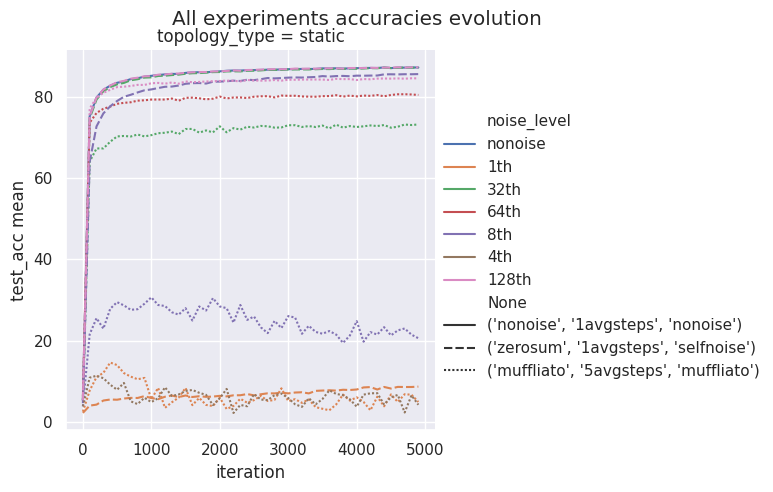

In [10]:
importlib.reload(plot_utils)
static_filter = {"topology_type" : ["static"] }
dynamic_filter = {"topology_type" : ["dynamic"]}

static_experiments =  plot_utils.filter_attribute(experiments_attributes,static_filter)
dynamic_experiments = plot_utils.filter_attribute(experiments_attributes,dynamic_filter)

#To display full experiments
display_attributes = {
    "hue": "noise_level",
    "style":["variant","avgsteps","additional_attribute"],
    "col" : "topology_type",
}

# To display experiment parameters tuning.
# display_attributes = {
#     "hue": "lr",
#     "style":"local_rounds",
#     "col" : "model",
# }

# To display muffliato results
# display_attributes = {
#     "hue":  "avgsteps",
#     "style":"variant",
#     "col" : "noise_level",
# }

for experiment in experiments_attributes:
    print(experiment)

plot_utils.plot_all_experiments(
    formatted_data,
    experiments_attributes,
    display_attributes,
    "All experiments accuracies evolution",
    "test_acc mean",
    save_directory=save_directory,
    # orderings = ORDERINGS,
)


## Noise cancellation vs no noise cancellation

2382294_nonoise_64nodes_1avgsteps_static_seed90_degree6_RNET_lr0.10_1rounds
2382295_zerosum_selfnoise_64nodes_1avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1rounds
2382296_zerosum_selfnoise_64nodes_1avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1rounds
2382297_zerosum_selfnoise_64nodes_1avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1rounds
2382298_zerosum_selfnoise_64nodes_1avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1rounds
Saving to assets/Test_accuracy_evolution_of_ZeroSum_with_and_without_self_noise.pdf


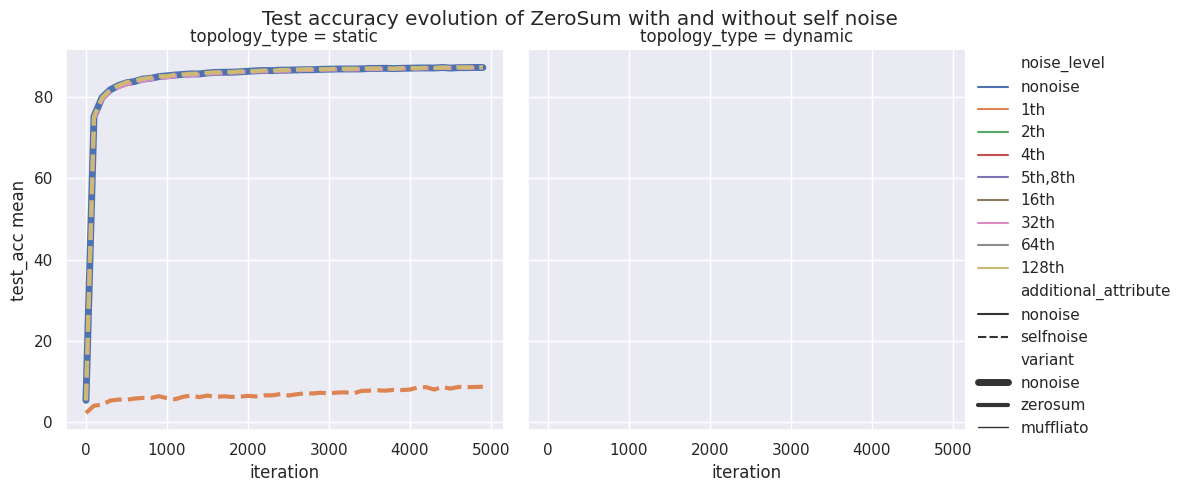

In [13]:

importlib.reload(plot_utils)
zerosum_attributes = {"variant":["nonoise","zerosum"]}
# zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["static"]}
# zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["dynamic"]}

display_attributes = {
    "hue":"noise_level",
    "style": "additional_attribute",
    "size": "variant",
    "col":"topology_type"
}

zerosum_experiments = plot_utils.filter_attribute(experiments_attributes,zerosum_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)

plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Test accuracy evolution of ZeroSum with and without self noise",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)



# Attack results
## In the static case:

2382294_nonoise_64nodes_1avgsteps_static_seed90_degree6_RNET_lr0.10_1rounds
2382295_zerosum_selfnoise_64nodes_1avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1rounds
2382296_zerosum_selfnoise_64nodes_1avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1rounds
2382297_zerosum_selfnoise_64nodes_1avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1rounds
2382298_zerosum_selfnoise_64nodes_1avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1rounds
Saving to assets/Attack_AUC_of_Zerosum_with_and_without_self_noise.pdf


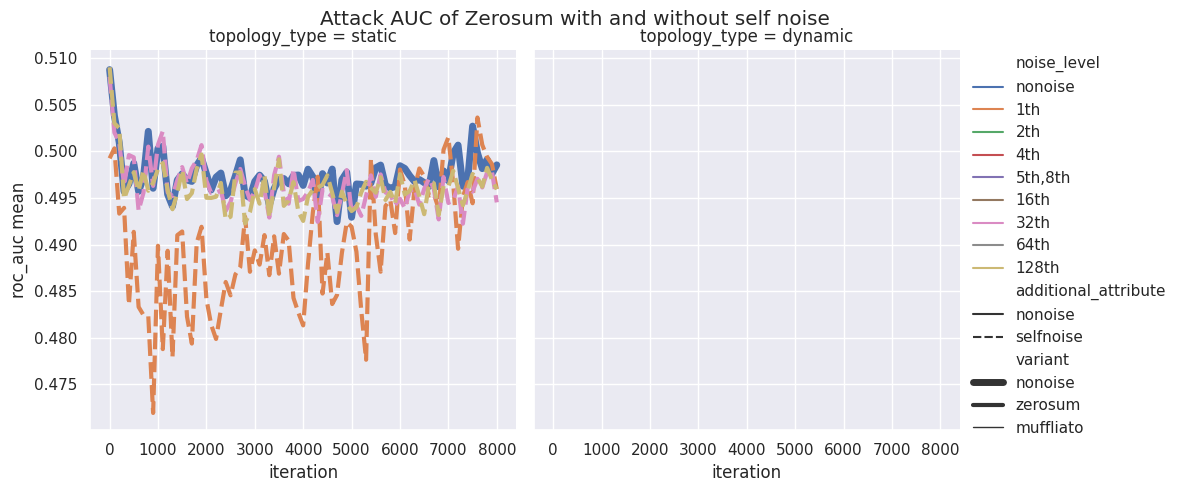

In [11]:
importlib.reload(plot_utils)
zerosum_attributes = {"variant":["nonoise","zerosum"]}
# zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["static"]}
# zerosum_attributes = {"variant":["nonoise","zerosum"],"topology_type":["dynamic"]}

display_attributes = {
    "hue":"noise_level",
    "style": "additional_attribute",
    "size": "variant",
    "col": "topology_type",
}

zerosum_experiments = plot_utils.filter_attribute(experiments_attributes,zerosum_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)

plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Attack AUC of Zerosum with and without self noise",
    "roc_auc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

# Results vs Muffliato

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2067553_zerosum_selfnoise_static_128nodes_1avgsteps_8th
2067554_zerosum_selfnoise_static_128nodes_1avgsteps_16th
2067638_zerosum_selfnoise_static_128nodes_1avgsteps_32th
2067654_zerosum_selfnoise_static_128nodes_1avgsteps_64th
2067675_zerosum_selfnoise_dynamic_128nodes_1avgsteps_8th
2067677_zerosum_selfnoise_dynamic_128nodes_1avgsteps_16th
2067678_zerosum_selfnoise_dynamic_128nodes_1avgsteps_32th
2067680_zerosum_selfnoise_dynamic_128nodes_1avgsteps_64th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2069875_muffliato_static_128nodes_10avgsteps_2th
2069886_muffliato_static_128nodes_10avgsteps_4th
2069887_muffliato_static_128nodes_10avgsteps_8th
2069889_muffliato_static_128nodes_10av

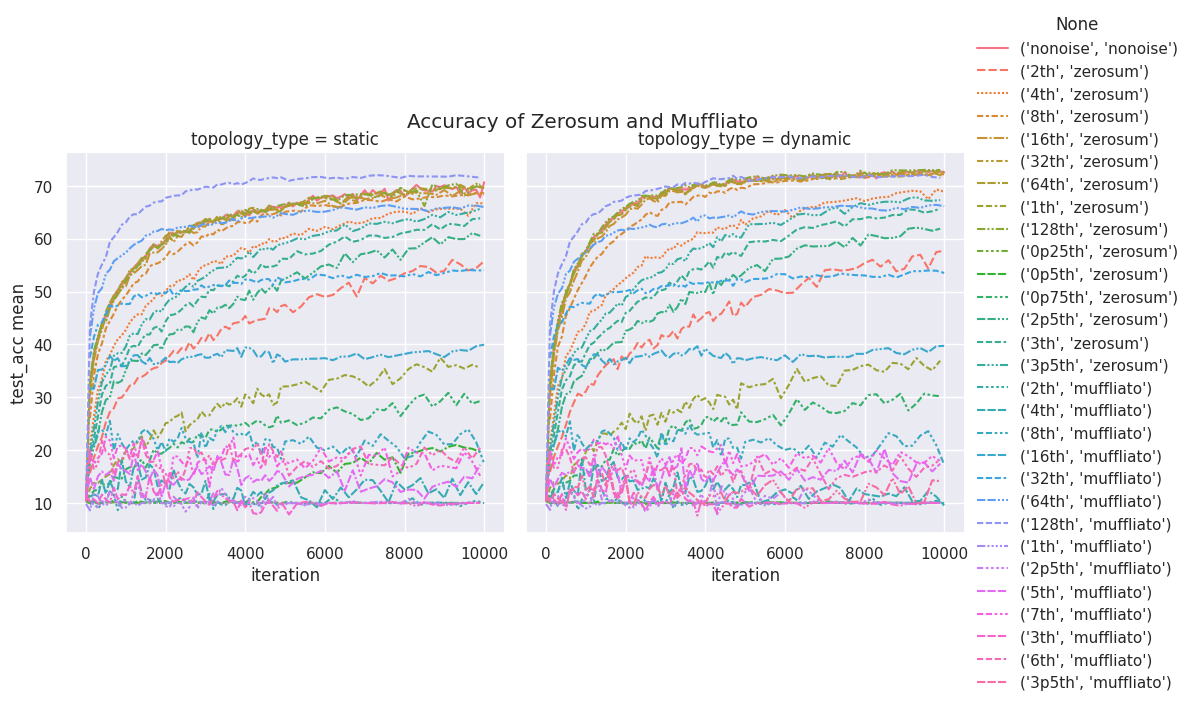

<Figure size 640x480 with 0 Axes>

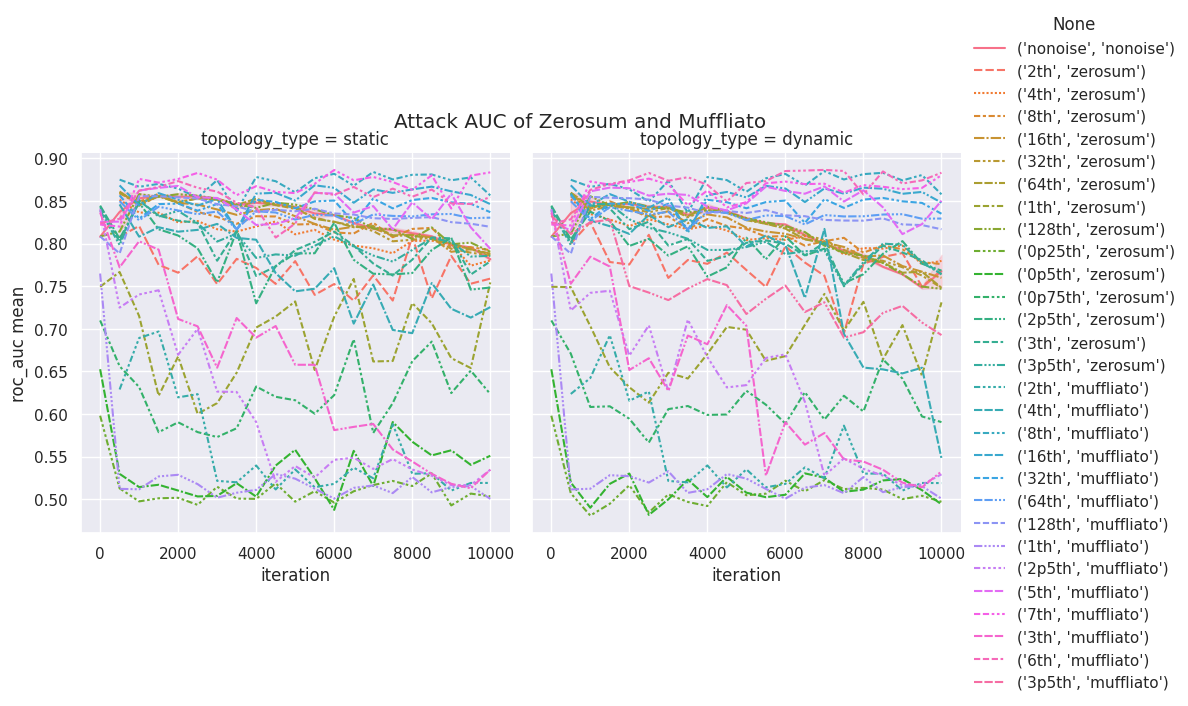

In [9]:
importlib.reload(plot_utils)

zerosum_attributes = {
    "variant":["zerosum","nonoise"],
    # "topology_type":["static"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"],
    # "avgsteps": ["1avgsteps","10avgsteps"],
    "additional_attribute": ["nonoise","selfnoise"]}
muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["static"],
    # "topology_type":["dynamic"],
    "avgsteps":["10avgsteps"],
}

current_attributes= [zerosum_attributes,muffliato_attributes]

# display_attributes = {
#     "hue":"noise_level",
#     "style":"variant",
#     # "size":"variant", # For some reason having both style and size breaks in this case.
#     "col":"topology_type",
# }

display_attributes = {
    "hue":["noise_level", "variant"],
    "style":["noise_level", "variant"],
    # "size":"variant", # For some reason having both style and size breaks in this case.
    "col":"topology_type",
}

zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)


plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy of Zerosum and Muffliato",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()
plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Attack AUC of Zerosum and Muffliato",
    "roc_auc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

### Smaller plots to have an easier time to read the information

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067551_zerosum_selfnoise_static_128nodes_1avgsteps_2th
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2068746_zerosum_selfnoise_dynamic_128nodes_1avgsteps_2th
2069875_muffliato_static_128nodes_10avgsteps_2th
2069886_muffliato_static_128nodes_10avgsteps_4th
2069893_muffliato_dynamic_128nodes_10avgsteps_2th
2069895_muffliato_dynamic_128nodes_10avgsteps_4th
2094445_zerosum_selfnoise_128nodes_1avgsteps_1th_static_seed90
2094452_zerosum_selfnoise_128nodes_1avgsteps_1th_dynamic_seed90
2094634_muffliato_128nodes_10avgsteps_1th_static_seed90
2094635_muffliato_128nodes_10avgsteps_1th_dynamic_seed90
4443235_nonoise_128nodes_1avgsteps_dynamic_seed90
4443409_nonoise_128nodes_1avgsteps_static_seed90
Saving to assets/High_noise:Accuracy_of_Zerosum_and_Muffliato_with_and_without_self_noise.pdf
Saving to as

(0.8224851346153846, 1.0)

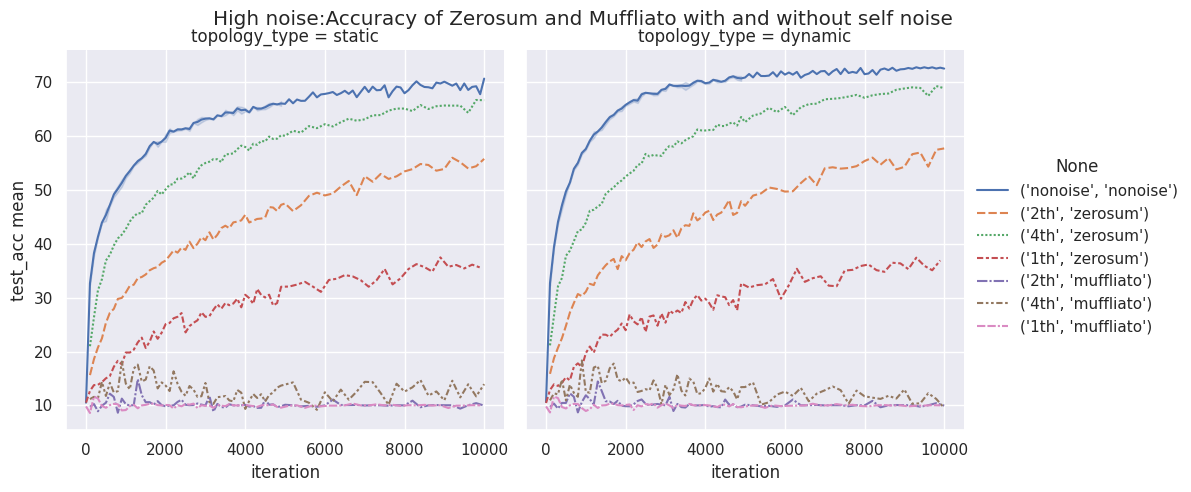

<Figure size 640x480 with 0 Axes>

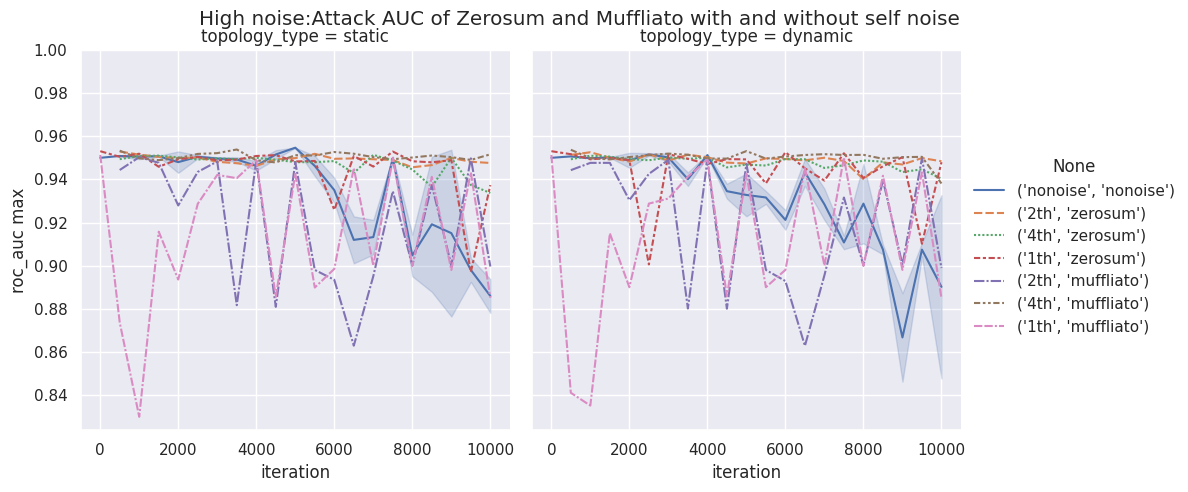

<Figure size 640x480 with 0 Axes>

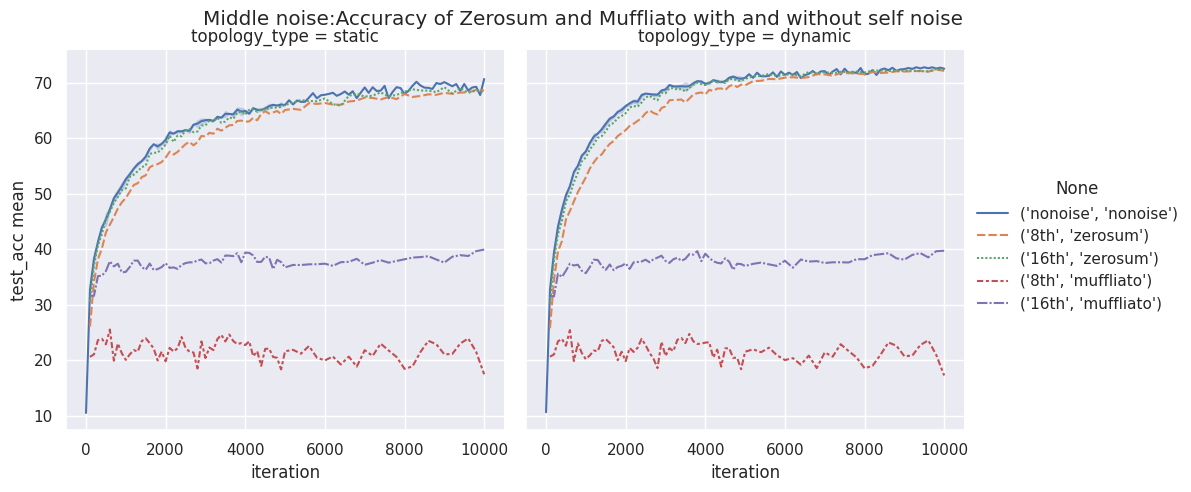

<Figure size 640x480 with 0 Axes>

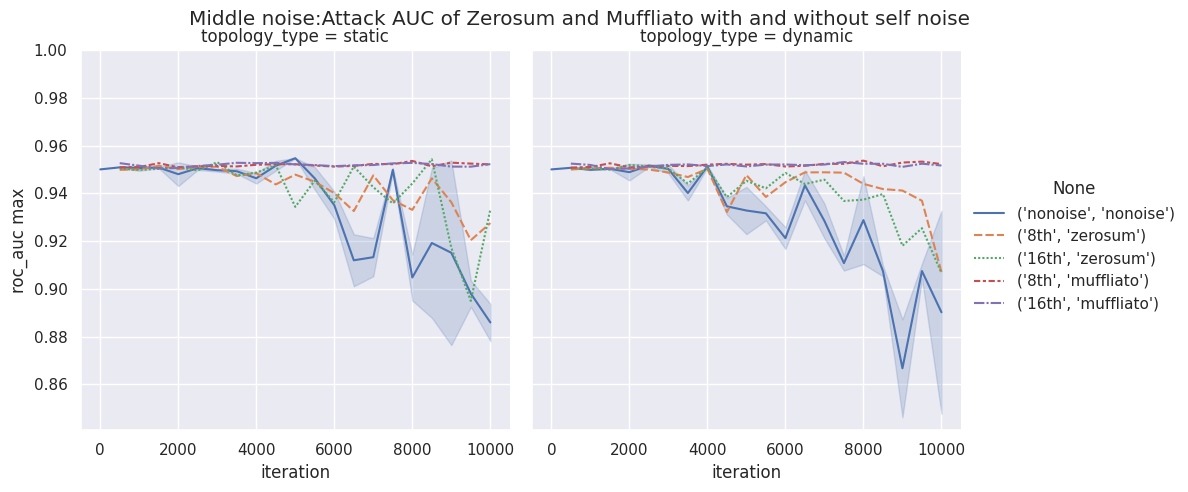

<Figure size 640x480 with 0 Axes>

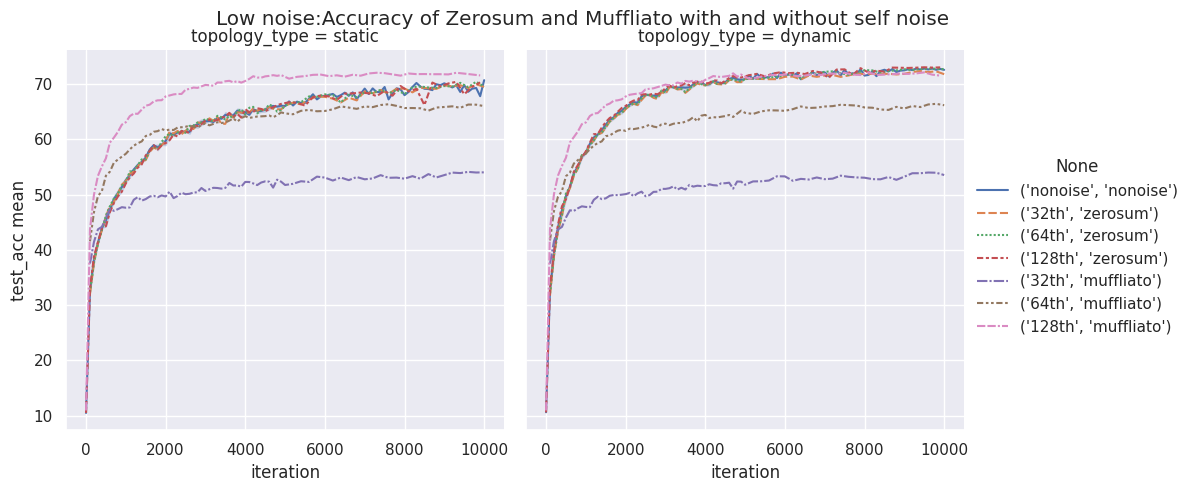

<Figure size 640x480 with 0 Axes>

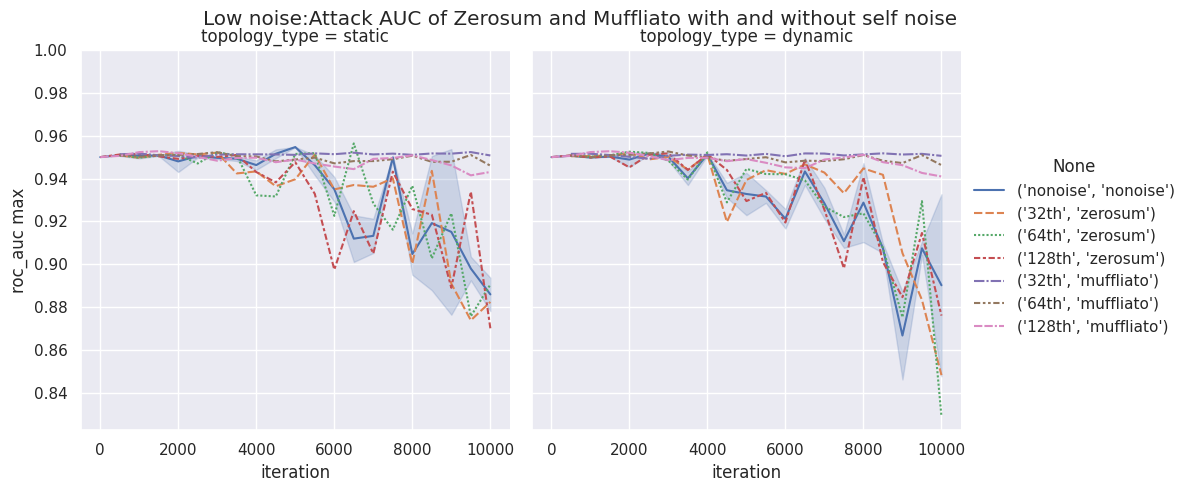

In [10]:
importlib.reload(plot_utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","1th","2th","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["1th","2th","4th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]


# display_attributes = {
#     "hue":"noise_level",
#     "style":"variant",
#     # "size":"variant", # For some reason having both style and size breaks in this case.
#     "col":"topology_type",
# }

display_attributes = {
    "hue":["noise_level", "variant"],
    "style":["noise_level", "variant"],
    # "size":"variant", # For some reason having both style and size breaks in this case.
    "col":"topology_type",
}

zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)



plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "High noise:Accuracy of Zerosum and Muffliato with and without self noise",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()

plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "High noise:Attack AUC of Zerosum and Muffliato with and without self noise",
    "roc_auc max",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.ylim(top=1)

# Plot the middle noises
importlib.reload(plot_utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","8th","16th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["8th","16th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.figure()
plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Middle noise:Accuracy of Zerosum and Muffliato with and without self noise",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()
plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Middle noise:Attack AUC of Zerosum and Muffliato with and without self noise",
    "roc_auc max",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.ylim(top=1)

# Plot the low noises
importlib.reload(plot_utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","32th","64th","128th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["32th","64th","128th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.figure()
plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Low noise:Accuracy of Zerosum and Muffliato with and without self noise",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()
plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Low noise:Attack AUC of Zerosum and Muffliato with and without self noise",
    "roc_auc max",
    save_directory=save_directory,
    orderings=ORDERINGS
)
plt.ylim(top=1)



# Trying out scatterplots

## Aggregated plots:

2382294_nonoise_64nodes_1avgsteps_static_seed90_degree6_RNET_lr0.10_1rounds
2382295_zerosum_selfnoise_64nodes_1avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1rounds
2382296_zerosum_selfnoise_64nodes_1avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1rounds
2382297_zerosum_selfnoise_64nodes_1avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1rounds
2382298_zerosum_selfnoise_64nodes_1avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1rounds
2383059_muffliato_64nodes_5avgsteps_128th_static_seed90_degree6_RNET_lr0.10_1rounds
2383060_muffliato_64nodes_5avgsteps_32th_static_seed90_degree6_RNET_lr0.10_1rounds
2383145_muffliato_64nodes_5avgsteps_8th_static_seed90_degree6_RNET_lr0.10_1rounds
2383146_muffliato_64nodes_5avgsteps_1th_static_seed90_degree6_RNET_lr0.10_1rounds
2383147_muffliato_64nodes_5avgsteps_64th_static_seed90_degree6_RNET_lr0.10_1rounds
2383148_muffliato_64nodes_5avgsteps_4th_static_seed90_degree6_RNET_lr0.10_1rounds
Saving to assets/Accuracy_vs_AUC_evolution_accross_entire_runs-st

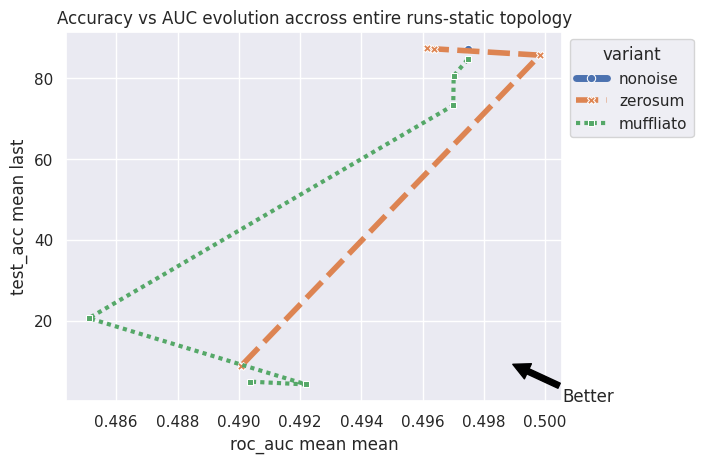

In [25]:
importlib.reload(plot_utils)
x_method = "mean"
# y_method = "max"
y_method = "last"

zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["5avgsteps"],
}

name_formater = {
    "test_acc mean max":"Maximum test accuracy [%]",
    "nonoise":"test"
}

current_attributes = [zerosum_attributes,muffliato_attributes]

display_attributes = {
    "hue":"variant",
    "style":"variant",
    "size":"variant", # For some reason having both style and size breaks in this case.
    # "col":"topology_type",# Cannot have col argument for the lineplot function
}
zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)


plot_utils.scatter_averaged_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Accuracy vs AUC evolution accross entire runs-static topology",
    "test_acc mean",
    "roc_auc percentile_95",
    save_directory=save_directory,
    y_method=y_method,
    x_method=x_method,
    orderings=ORDERINGS,
    name_formater=name_formater,
)

# plt.figure()
# plot_utils.scatter_averaged_experiments(
#     formatted_data,
#     zerosum_experiments,
#     display_attributes,
#     "Accuracy vs Linkability attack for the entire run-static topology",
#     "test_acc mean",
#     "linkability_top1 count_percentage_success",
#     save_directory=save_directory,
#     y_method=y_method,
#     x_method=x_method,
#     orderings=ORDERINGS,
#     name_formater=name_formater,
# )

zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"],
}
current_attributes = [zerosum_attributes,muffliato_attributes]
zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)

# plt.figure()
# plot_utils.scatter_averaged_experiments(
#     formatted_data,
#     zerosum_experiments,
#     display_attributes,
#     "Accuracy vs AUC evolution accross entire runs-dynamic topology",
#     "test_acc mean",
#     "roc_auc percentile_95",
#     save_directory=save_directory,
#     y_method=y_method,
#     x_method=x_method,
#     orderings=ORDERINGS,
#     name_formater=name_formater,
# )

# plt.figure()
# plot_utils.scatter_averaged_experiments(
#     formatted_data,
#     zerosum_experiments,
#     display_attributes,
#     "Accuracy vs Linkability attack for the entire run-dynamic topology",
#     y_axis_name="test_acc mean",
#     x_axis_name="linkability_top1 count_percentage_success",
#     save_directory=save_directory,
#     y_method=y_method,
#     x_method=x_method,
#     orderings=ORDERINGS,
#     name_formater=name_formater,
# )

# plt.figure()
# plot_utils.scatter_averaged_experiments(
#     formatted_data,
#     zerosum_experiments,
#     display_attributes,
#     "Accuracy vs Linkability top5 attack for the entire run-dynamic topology",
#     y_axis_name="test_acc mean",
#     x_axis_name="linkability_top5 count_percentage_success",
#     save_directory=save_directory,
#     y_method=y_method,
#     x_method=x_method,
#     orderings=ORDERINGS,
#     name_formater=name_formater,
# )

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
4443409_nonoise_128nodes_1avgsteps_static_seed90


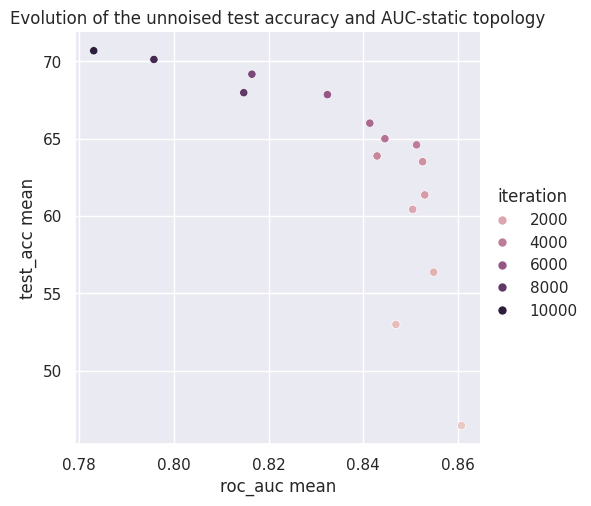

In [12]:
importlib.reload(plot_utils)
zerosum_attributes = {
    "variant":["nonoise"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"],
    # "noise_level":[None,"2th","4th"]
}


zerosum_experiments = plot_utils.filter_attribute(experiments_attributes,zerosum_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)


experiment = zerosum_experiments[0]
experiment_data = formatted_data[experiment] 

sns.set_theme()
sns.relplot(data=experiment_data, x="roc_auc mean", y="test_acc mean", hue="iteration")

title = "Evolution of the unnoised test accuracy and AUC-static topology"
plt.title(title)
plt.savefig(save_directory + title.replace(" ","_") +".pdf")

## Better experiment display (selected noises levels)

2067267_nonoise_static_128nodes_1avgsteps_batch32_lr0.05_3rounds
2067277_nonoise_dynamic_128nodes_1avgsteps_batch32_lr0.05_3rounds
4443235_nonoise_128nodes_1avgsteps_dynamic_seed90
4443409_nonoise_128nodes_1avgsteps_static_seed90
2067552_zerosum_selfnoise_static_128nodes_1avgsteps_4th
2068745_zerosum_selfnoise_dynamic_128nodes_1avgsteps_4th
2069891_muffliato_static_128nodes_10avgsteps_64th
2069899_muffliato_dynamic_128nodes_10avgsteps_64th
Saving to assets/Selected_noise:Accuracy_of_Zerosum_and_Muffliato.pdf


KeyError: "['roc_auc mean_start_avg'] not in index"

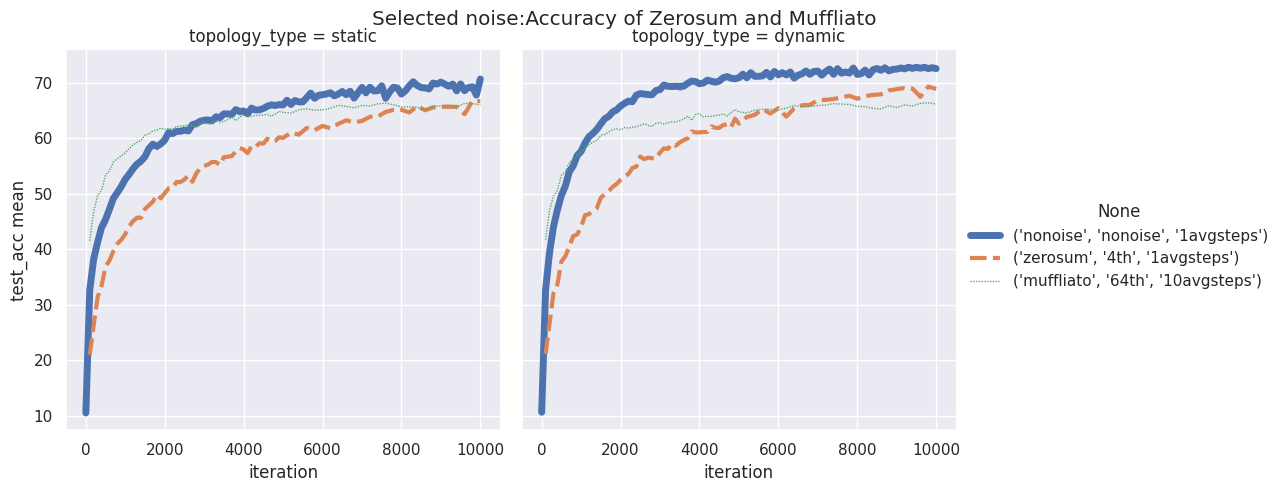

<Figure size 640x480 with 0 Axes>

In [13]:
importlib.reload(plot_utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

display_attributes = {
    "hue":["variant","noise_level","avgsteps"],
    "style":["variant","noise_level","avgsteps"],
    "size":["variant","noise_level","avgsteps"], # For some reason having both style and size breaks in this case.
    "col":"topology_type",
}

order_mapper = {"muffliato":2,"nonoise":0,"zerosum":1}
zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)
zerosum_experiments = sorted(zerosum_experiments, key = lambda x : order_mapper[x.split("_")[1]])
for experiment in zerosum_experiments:
    print(experiment)
# zerosum_experiments = [zerosum_experiments[i] for i in [0,1,4,5,2,3] ]



plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Accuracy of Zerosum and Muffliato",
    "test_acc mean",
    save_directory=save_directory,
    orderings = ORDERINGS,
)


plt.figure()

plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Attack AUC of Zerosum and Muffliato",
    "roc_auc mean_start_avg",
    save_directory=save_directory,
    orderings = ORDERINGS,
)

plt.figure()

plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Linkability attack ac of Zerosum and Muffliato",
    "linkability_top1 count_percentage_success_start_avg",
    save_directory=save_directory,
    orderings = ORDERINGS,
)

plt.figure()

#Needs to only have hue since we can't have other attributes in jointplots
display_attributes = {
    "hue":["variant","noise_level","avgsteps"],
}

zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)
print("-"*40)


plot_utils.scatter_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Accuracy vs AUC-static",
    "roc_auc mean",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.figure()
plot_utils.scatter_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise:Accuracy vs Linkability sucess rate-static",
    "linkability_top1 count_percentage_success",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

In [ ]:
importlib.reload(plot_utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","1th","2th","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["1th","2th","4th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]


display_attributes = {
    "hue":"noise_level",
    "style":"variant",
    "size":"avgsteps", # For some reason having both style and size breaks in this case.
    "col":"topology_type",
}

zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)



plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "High noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()

plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "High noise:Linkability attack accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

# Plot the middle noises
importlib.reload(plot_utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","8th","16th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["8th","16th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.figure()
plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Middle noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()
plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Middle noise:Linkability attack accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    orderings=ORDERINGS,
)


# Plot the low noises
importlib.reload(plot_utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","32th","64th","128th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["32th","64th","128th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)

plt.figure()
plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Low noise:Accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

plt.figure()
plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Low noise:Linkability attack accuracy of Zerosum and Muffliato with and without self noise-dynamic topology",
    "linkability_top1 count_percentage_success",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.ylim(top=1)



# Start average trial displays

In [ ]:
importlib.reload(plot_utils)
zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    # "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

display_attributes = {
    "hue":["variant","noise_level","avgsteps"],
    "style":["variant","noise_level","avgsteps"],
    "size":["variant","noise_level","avgsteps"], # For some reason having both style and size breaks in this case.
    "col":"topology_type",
}

order_mapper = {"muffliato":2,"nonoise":0,"zerosum":1}
zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)
zerosum_experiments = sorted(zerosum_experiments,key = lambda x : order_mapper[x.split("_")[1]])
for experiment in sorted(zerosum_experiments):
    print(experiment)



plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise: Accuracy of Zerosum and Muffliato",
    "test_acc mean",
    save_directory=save_directory,
    orderings = ORDERINGS,
)


plt.figure()

plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise: Threshold AUC rolling average of Zerosum and Muffliato",
    "roc_auc mean_start_avg",
    save_directory=save_directory,
    orderings = ORDERINGS,
)

plt.figure()

plot_utils.plot_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise: Linkability attack rolling average ac of Zerosum and Muffliato",
    "linkability_top1 count_percentage_success_start_avg",
    save_directory=save_directory,
    orderings = ORDERINGS,
)

plt.figure()

#Needs to only have hue since we can't have other attributes in jointplots
display_attributes = {
    "hue":["variant","noise_level","avgsteps"],
}

zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    "noise_level":["nonoise","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"], 
    "noise_level":["64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)
print("-"*40)


plot_utils.scatter_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise: Accuracy vs Threshold AUC rolling average-static",
    "roc_auc mean_start_avg",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)
plt.figure()
plot_utils.scatter_all_experiments(
    formatted_data,
    zerosum_experiments,
    display_attributes,
    "Selected noise: Accuracy vs Linkability sucess rate rolling average-static",
    "linkability_top1 count_percentage_success_start_avg",
    "test_acc mean",
    save_directory=save_directory,
    orderings=ORDERINGS,
)

In [ ]:
last_expe = list(formatted_data.keys())[-1]
print(formatted_data[last_expe]["noise_level"])

# Display the test loss and test accuracy of inflexion point.

In [ ]:
importlib.reload(plot_utils)

muffliato_attributes = {
    "variant":["zerosum"],
    "additional_attribute":["selfnoise"],
    # "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "noise_level":["6th",
        "7th",
        "8th",
        "16th",
        "32th","64th","128th"]
}
current_attributes= [muffliato_attributes]

display_attributes = {
    "hue":["variant","noise_level_value"],
    # "style":["variant","noise_level","avgsteps"],
    # "size":["variant","noise_level","avgsteps"], # For some reason having both style and size breaks in this case.
    "col":"topology_type",
}

muffliato_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in muffliato_experiments:
    print(experiment)

plot_utils.plot_all_experiments(
    formatted_data,
    muffliato_experiments,
    display_attributes,
    "Inflexion point: test_acc of Muffliato",
    "test_acc mean",
    save_directory=save_directory,
    # orderings = ORDERINGS,
)
plt.figure()
plot_utils.plot_all_experiments(
    formatted_data,
    muffliato_experiments,
    display_attributes,
    "Inflexion point: test_loss of Muffliato",
    "test_loss mean",
    save_directory=save_directory,
    # orderings = ORDERINGS,
)

# Data displays

In [ ]:
importlib.reload(plot_utils)

target_accuracy = 50


zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["static"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    # "noise_level":["nonoise","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["static"],
    "avgsteps": ["10avgsteps"], 
    # "noise_level":["64th"]
}
current_attributes= [zerosum_attributes,muffliato_attributes]

zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)
for experiment in sorted(zerosum_experiments):
    print(experiment)
order = ORDERINGS["noise_level"]
order_mapper = {"muffliato":2,"nonoise":1,"zerosum":0}
zerosum_experiments = sorted(zerosum_experiments, key = lambda x : order_mapper[x.split("_")[1]])

plot_utils.plot_communication(formatted_data,zerosum_experiments,target_accuracy,f"Communications to reach {target_accuracy}% accuracy-static",save_directory=save_directory,order=order)

zerosum_attributes = {
    "variant":["nonoise","zerosum"],
    "topology_type":["dynamic"],
    "avgsteps": ["1avgsteps"], 
    "additional_attribute": ["nonoise","selfnoise"],
    # "noise_level":["nonoise","4th"]
}

muffliato_attributes = {
    "variant":["muffliato"],
    "topology_type":["dynamic"],
    "avgsteps": ["10avgsteps"], 
    # "noise_level":["64th"]
}

current_attributes= [zerosum_attributes,muffliato_attributes]
zerosum_experiments = plot_utils.filter_attribute_list(experiments_attributes,current_attributes)

order = ORDERINGS["noise_level"]
order_mapper = {"muffliato":2,"nonoise":0,"zerosum":1}
zerosum_experiments = sorted(zerosum_experiments, key = lambda x : order_mapper[x.split("_")[1]])

plt.figure()
plot_utils.plot_communication(formatted_data,zerosum_experiments,target_accuracy,f"Communications to reach {target_accuracy}% accuracy-dynamic",save_directory=save_directory,order=order)
